In [1]:
import numpy as np
import torch 
import torch.nn as nn
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader

import sys
from pathlib import Path
sys.path.insert(0, r"C:\Users\isakb\Documents\M.Sc Physics\Code\GNN_decoder_quant")

from src.simulations import SurfaceCodeSim
from src.graph_representation import get_3D_graph
from src.gnn_models import QGNN_7, GNN_7
from src.utils import match_and_load_state_dict, plot_weights

import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

from icecream import ic
ic.configureOutput(includeContext=True)

#### Settings

In [2]:
model_path = Path.cwd().parent / Path("models\circuit_level_noise\d7\d7_d_t_11.pt")
device = torch.device("cpu")
n_graphs = 2000
seed = None
batch_size = n_graphs if n_graphs < 5000 else 5000
p = 3e-3

# read code distance and number of repetitions from file name
file_name = model_path.name
splits = file_name.split("_")
code_sz = int(splits[0][1])
reps = int(splits[3].split(".")[0])

##### Create model and load pre-trained weights

In [3]:
model = GNN_7().to(device)
float_model = GNN_7().to(device)

trained_weights = torch.load(model_path, map_location=device)["model"]
model = match_and_load_state_dict(model, trained_weights)
float_model = match_and_load_state_dict(float_model, trained_weights)

model.eval()
float_model.eval()

GNN_7(
  (graph_layers): ModuleList(
    (0): GraphConv(5, 32)
    (1): GraphConv(32, 128)
    (2): GraphConv(128, 256)
    (3): GraphConv(256, 512)
    (4): GraphConv(512, 512)
    (5): GraphConv(512, 256)
    (6): GraphConv(256, 256)
  )
  (dense_layers): ModuleList(
    (0): Linear(in_features=256, out_features=256, bias=True)
    (1): Linear(in_features=256, out_features=128, bias=True)
    (2): Linear(in_features=128, out_features=64, bias=True)
  )
  (output_layer): Linear(in_features=64, out_features=1, bias=True)
)

In [11]:
for key, val in model.state_dict().items():
    print(key)
    print(val.shape)

graph_layers.0.lin_rel.weight
torch.Size([32, 5])
graph_layers.0.lin_rel.bias
torch.Size([32])
graph_layers.0.lin_root.weight
torch.Size([32, 5])
graph_layers.1.lin_rel.weight
torch.Size([128, 32])
graph_layers.1.lin_rel.bias
torch.Size([128])
graph_layers.1.lin_root.weight
torch.Size([128, 32])
graph_layers.2.lin_rel.weight
torch.Size([256, 128])
graph_layers.2.lin_rel.bias
torch.Size([256])
graph_layers.2.lin_root.weight
torch.Size([256, 128])
graph_layers.3.lin_rel.weight
torch.Size([512, 256])
graph_layers.3.lin_rel.bias
torch.Size([512])
graph_layers.3.lin_root.weight
torch.Size([512, 256])
graph_layers.4.lin_rel.weight
torch.Size([512, 512])
graph_layers.4.lin_rel.bias
torch.Size([512])
graph_layers.4.lin_root.weight
torch.Size([512, 512])
graph_layers.5.lin_rel.weight
torch.Size([256, 512])
graph_layers.5.lin_rel.bias
torch.Size([256])
graph_layers.5.lin_root.weight
torch.Size([256, 512])
graph_layers.6.lin_rel.weight
torch.Size([256, 256])
graph_layers.6.lin_rel.bias
torch.Size

#### Visualise distribution of weights

(<Figure size 1200x2800 with 21 Axes>, <Figure size 800x1600 with 8 Axes>)

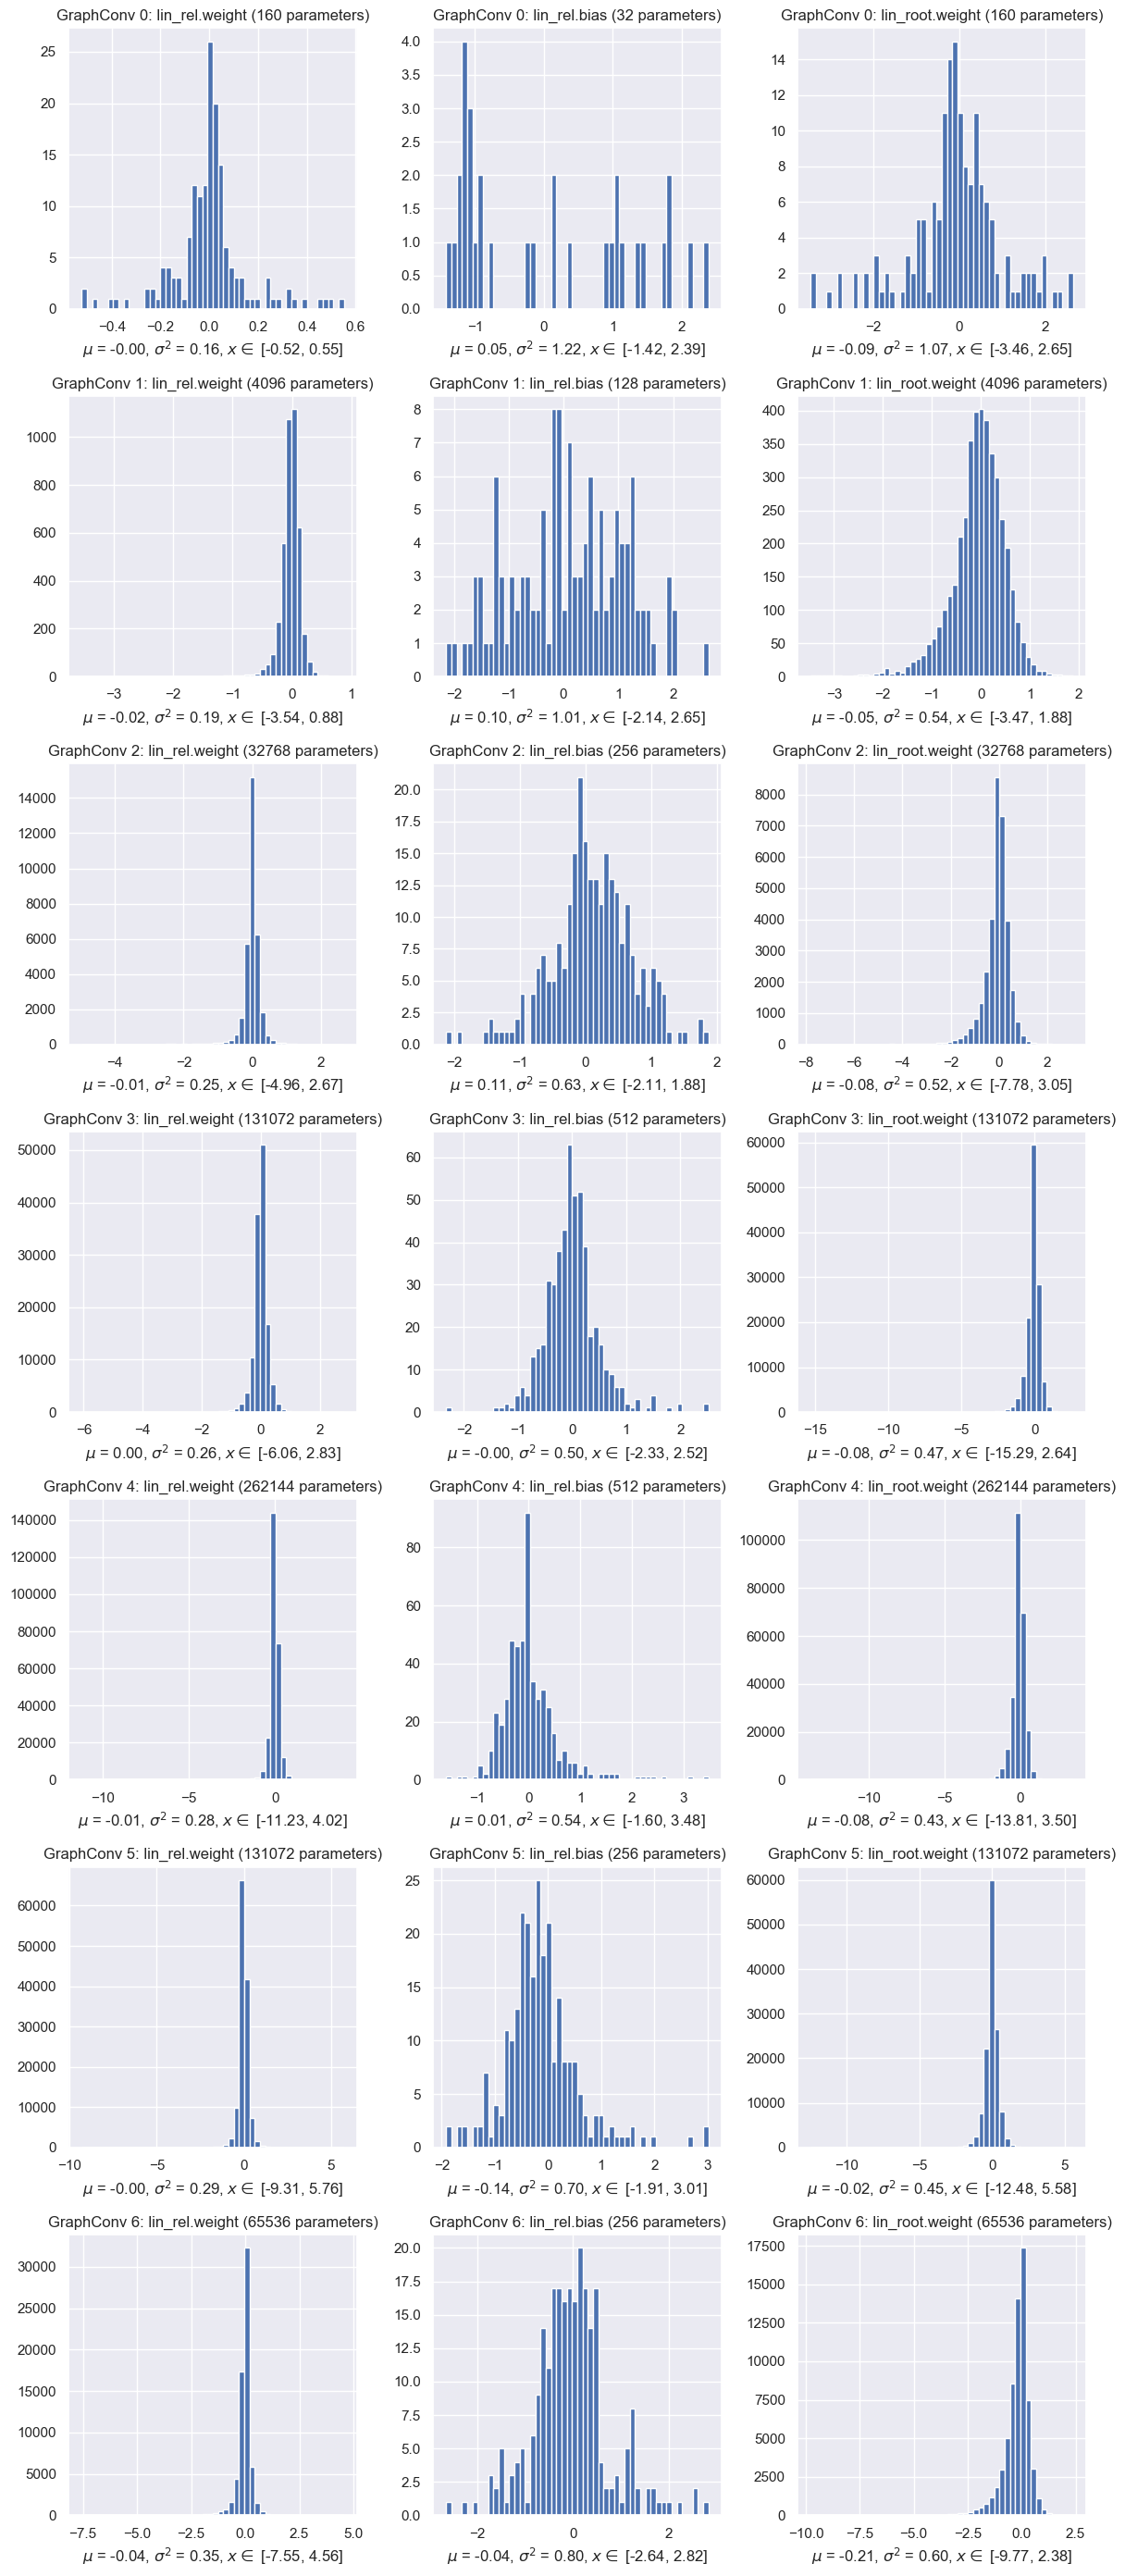

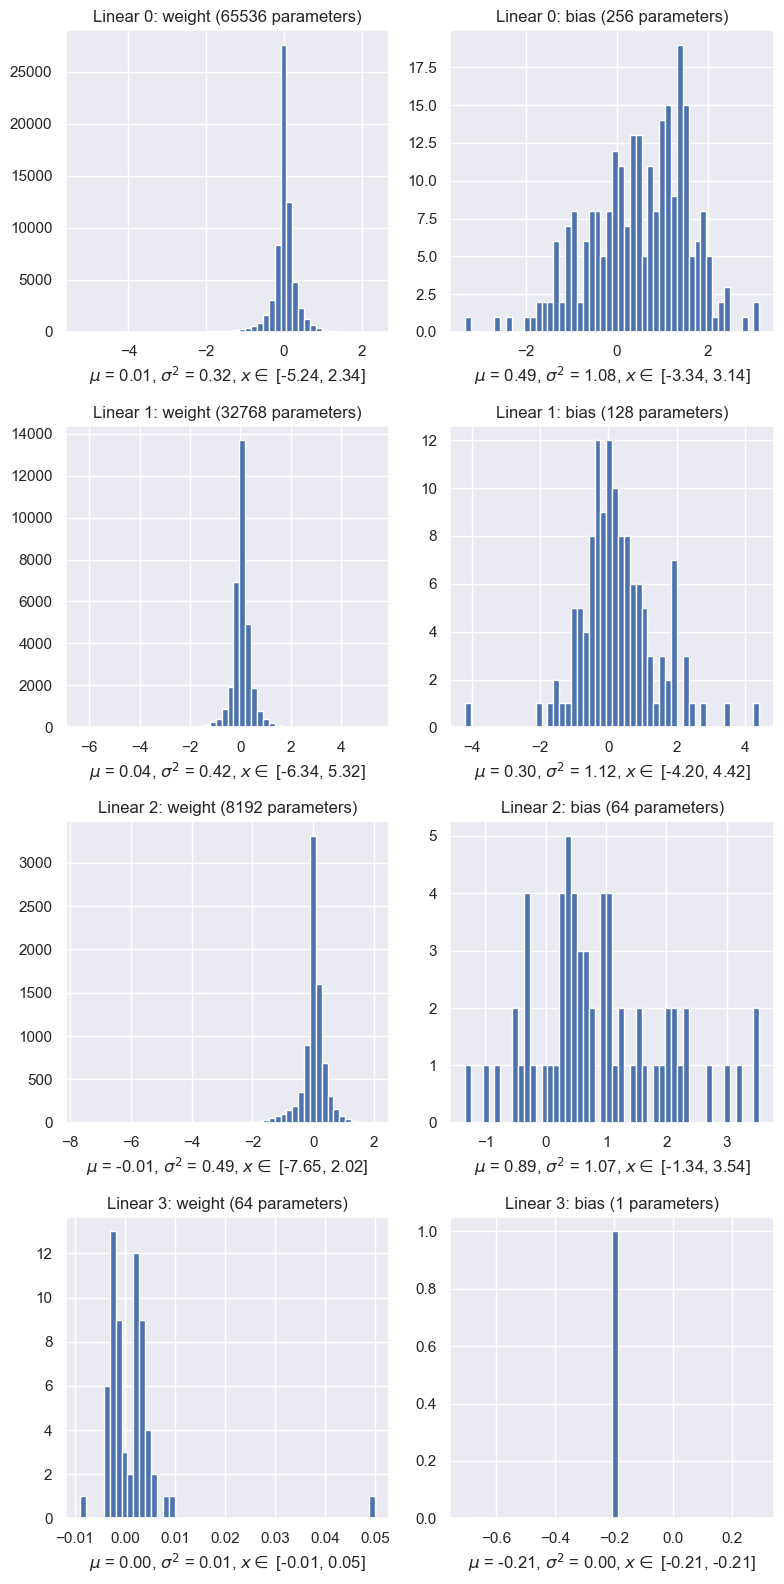

In [4]:
plot_weights(7, 4, model.state_dict())

##### Make sure quantization looks reasonable

ic| 379610588.py:9 in <module>- scale: tensor(0.7857)
ic| 379610588.py:10 in <module>- zero_pt: tensor(2.)
ic| 379610588.py:26 in <module>- q.min(): tensor(0.)
ic| 379610588.py:27 in <module>- q.max(): tensor(7.)


Quantizing a real zero and then dequantizing it again gives the error: 0.0.


tensor(7.)

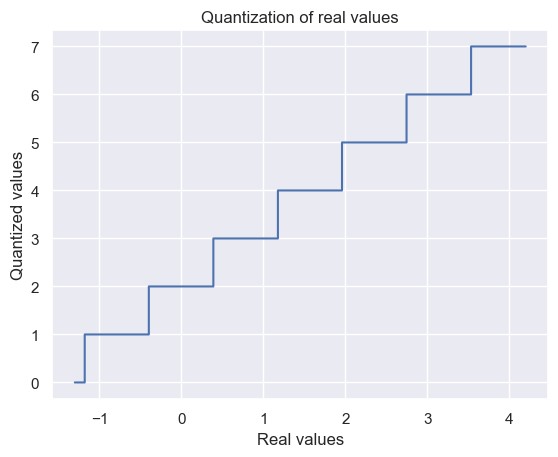

In [5]:
from src.utils import get_scale, get_zero_pt, quantize_tensor, dequantize_tensor

bit_width = 3
alpha = torch.tensor(-1.3)
beta = torch.tensor(4.2)

scale = get_scale(alpha, beta, bit_width)
zero_pt = get_zero_pt(alpha, beta, bit_width, signed=False)
ic(scale)
ic(zero_pt)

r = torch.tensor(np.linspace(alpha, beta, 1000)).float()
q = quantize_tensor(r, scale, zero_pt, bit_width=bit_width, signed=False)

fig, ax = plt.subplots()
ax.step(r, q)
ax.set_title("Quantization of real values")
ax.set_xlabel("Real values")
ax.set_ylabel("Quantized values")

# quantizing a real zero and then dequantizing
real_zero = torch.tensor(0)
q_zero = quantize_tensor(real_zero, scale, zero_pt, bit_width=bit_width)
new_real_zero = dequantize_tensor(q_zero, scale, zero_pt)
print(f"Quantizing a real zero and then dequantizing it again gives the error: {real_zero - new_real_zero}.")
ic(q.min())
ic(q.max())

In [20]:
import re
all_names = list(model.state_dict().keys())
graph_weights = np.array([name for name in all_names if "graph" in name and "weight" in name]).reshape(-1, 2).tolist()
graph_bias = [[name] for name in all_names if "graph" in name and "bias" in name]
lin_weights = [[name] for name in all_names if not "graph" in name and "weight" in name]
lin_bias = [[name] for name in all_names if not "graph" in name and "bias" in name]
layers = graph_weights + graph_bias + lin_weights + lin_bias
ic(layers)




ic| 2567448940.py:8 in <module>
    layers: [['graph_layers.0.lin_rel.weight', 'graph_layers.0.lin_root.weight'],
             ['graph_layers.1.lin_rel.weight', 'graph_layers.1.lin_root.weight'],
             ['graph_layers.2.lin_rel.weight', 'graph_layers.2.lin_root.weight'],
             ['graph_layers.3.lin_rel.weight', 'graph_layers.3.lin_root.weight'],
             ['graph_layers.4.lin_rel.weight', 'graph_layers.4.lin_root.weight'],
             ['graph_layers.5.lin_rel.weight', 'graph_layers.5.lin_root.weight'],
             ['graph_layers.6.lin_rel.weight', 'graph_layers.6.lin_root.weight'],
             ['graph_layers.0.lin_rel.bias'],
             ['graph_layers.1.lin_rel.bias'],
             ['graph_layers.2.lin_rel.bias'],
             ['graph_layers.3.lin_rel.bias'],
             ['graph_layers.4.lin_rel.bias'],
             ['graph_layers.5.lin_rel.bias'],
             ['graph_layers.6.lin_rel.bias'],
             ['dense_layers.0.weight'],
             ['dense_layers.1.we

['Graph layer 0 - weights',
 'Graph layer 1 - weights',
 'Graph layer 2 - weights',
 'Graph layer 3 - weights',
 'Graph layer 4 - weights',
 'Graph layer 5 - weights',
 'Graph layer 6 - weights',
 'Graph layer 0 - bias',
 'Graph layer 1 - bias',
 'Graph layer 2 - bias',
 'Graph layer 3 - bias',
 'Graph layer 4 - bias',
 'Graph layer 5 - bias',
 'Graph layer 6 - bias',
 'Linear layer 0 - weights',
 'Linear layer 1 - weights',
 'Linear layer 2 - weights',
 'Linear layer 0 - bias',
 'Linear layer 1 - bias',
 'Linear layer 2 - bias',
 'Output layer - weight',
 'Output layer - bias']

(<Figure size 1200x2800 with 21 Axes>, <Figure size 800x1600 with 8 Axes>)

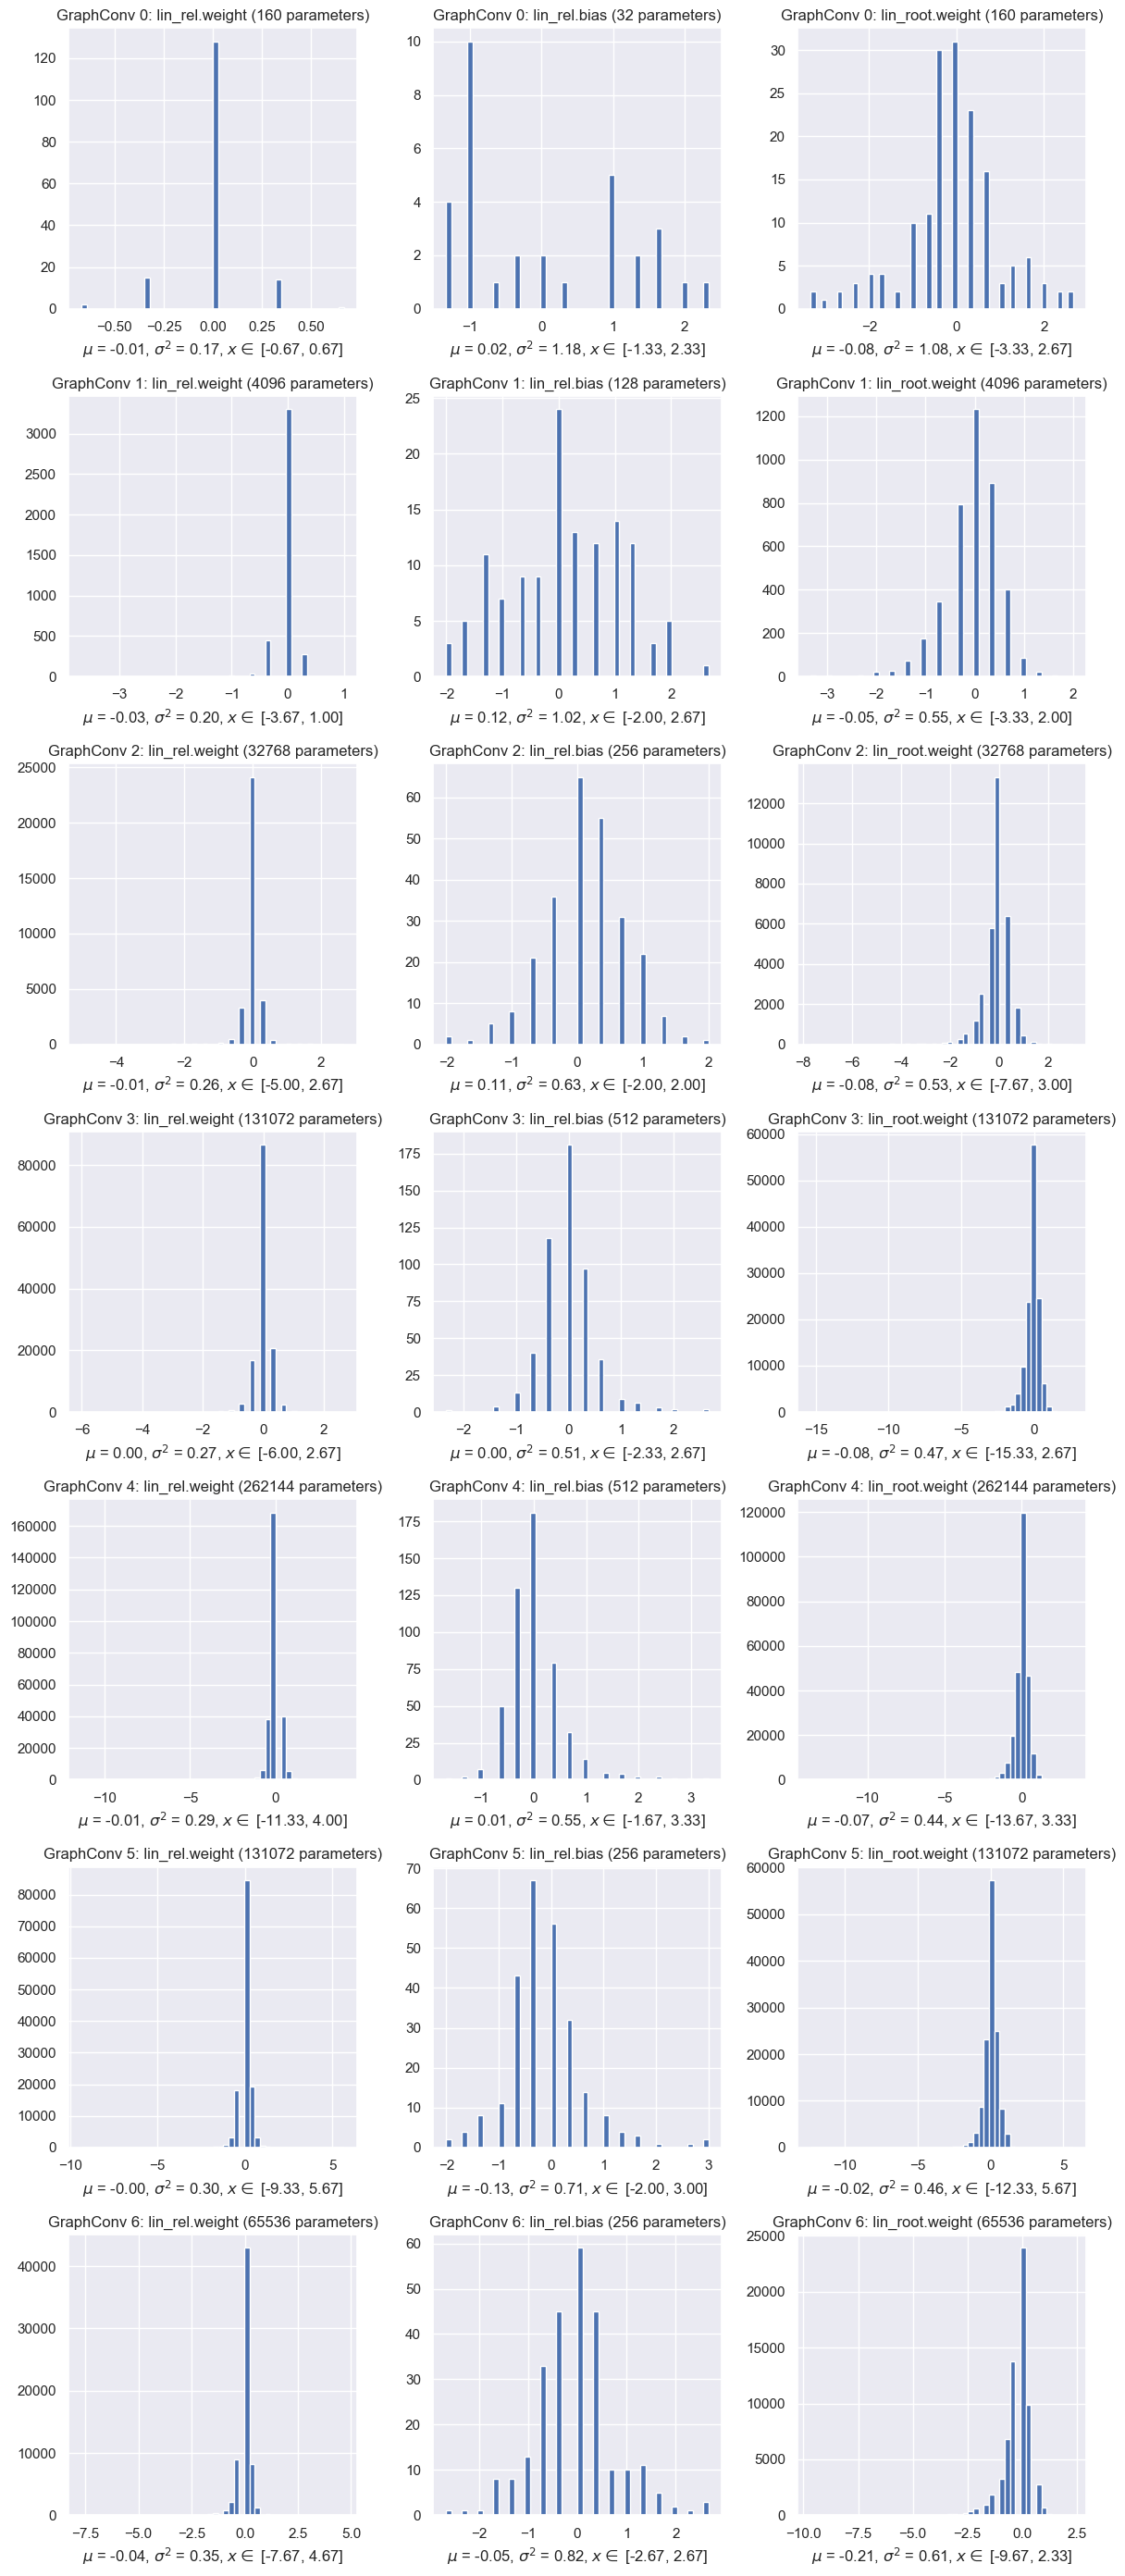

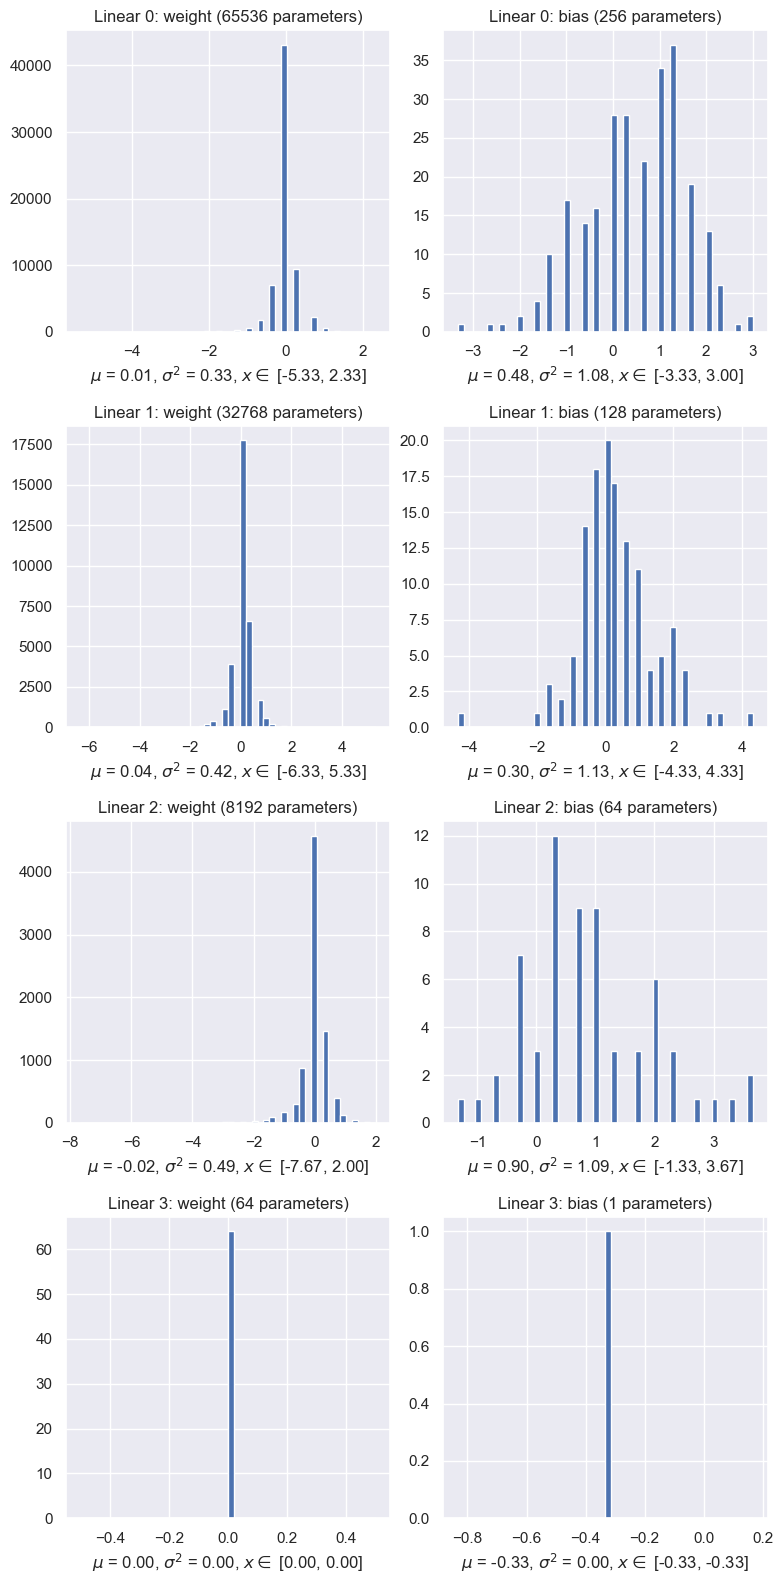

In [30]:
from src.utils import fixed_precision_model_layers

bit_width = 2
model = GNN_7()
model = match_and_load_state_dict(model, trained_weights)
fixed_precision_model_layers(model, bit_width)
plot_weights(7, 4, model.state_dict())


##### Generate data to test performance

In [6]:
sim = SurfaceCodeSim(reps, code_sz, p, n_shots=n_graphs, seed=seed)

syndromes, flips = sim.generate_syndromes(n_graphs)

graphs = []
for syndrome, flip in zip(syndromes, flips):
    x, edge_index, edge_attr, y = get_3D_graph(
        syndrome_3D=syndrome, target=flip, m_nearest_nodes=5
    )
    graphs.append(Data(x, edge_index, edge_attr, y))
loader = DataLoader(graphs, batch_size=batch_size)

##### Compare accuracies of different bit widths

Text(0, 0.5, 'Quantization error')

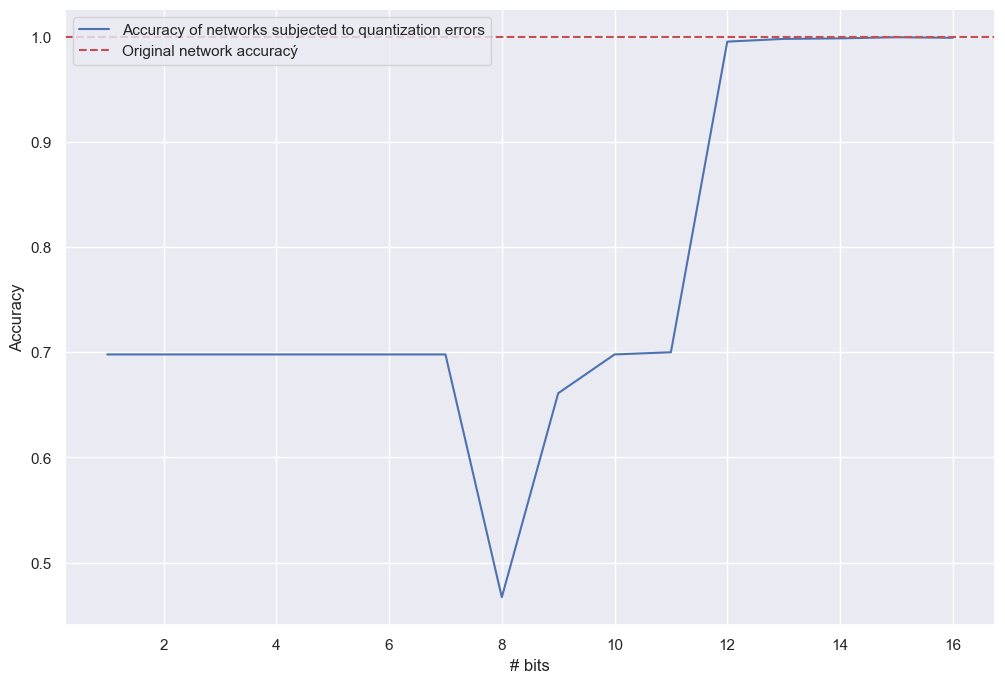

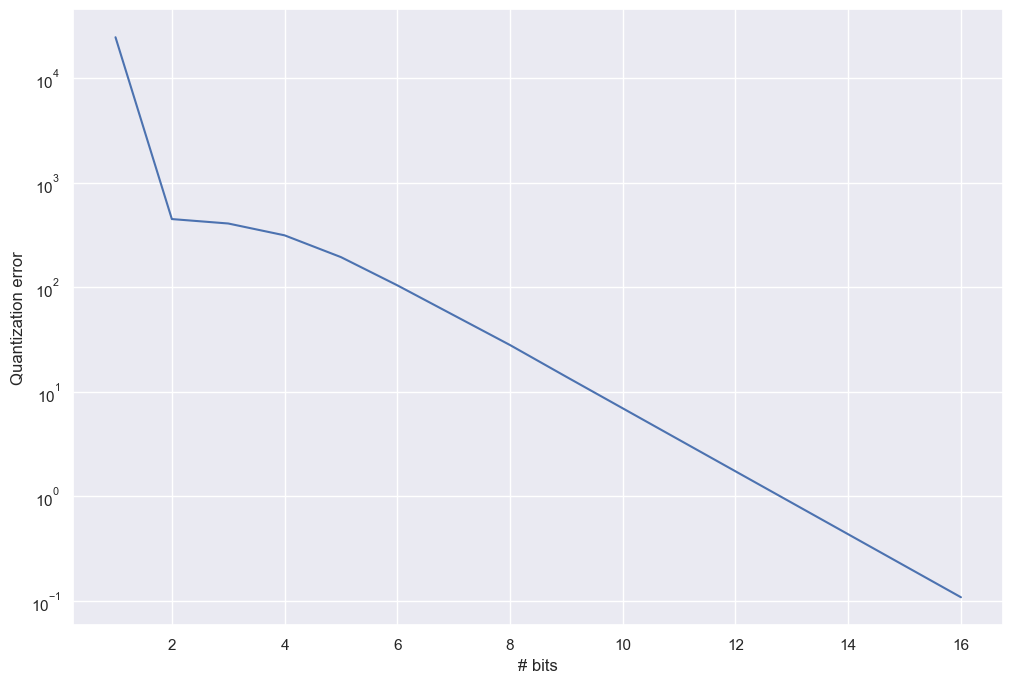

In [7]:
# we begin by quantizing the entire model
from src.utils import (
    quantize_model_layers,
    dequantize_model_layers,
    run_inference,
    get_all_weights,
)

end_range = 16
bit_widths = np.arange(1, end_range + 1, dtype=np.int64)
all_weights = get_all_weights(model)
qt = 0.00
lower_limit = torch.tensor(np.quantile(all_weights, qt))
upper_limit = torch.tensor(np.quantile(all_weights, 1 - qt))

# upper_limit = torch.concatenate((lower_limit.abs(), upper_limit.abs())).max()
# lower_limit = -upper_limit

accuracies = []
q_errors = []
for bit_width in bit_widths:
    model = GNN_7()
    model = match_and_load_state_dict(model, trained_weights)
    scale = get_scale(lower_limit, upper_limit, bit_width)
    zero_pt = get_zero_pt(lower_limit, upper_limit, bit_width)

    quantized_layers, scale, zero_pt = quantize_model_layers(
        model,
        bit_width,
        scale=scale,
        zero_pt=zero_pt,
        same_quantization=True,
    )
    
    dequantized_layers = dequantize_model_layers(model, scale, zero_pt)
    dq_weights = get_all_weights(model)
    
    q_error = np.linalg.norm(all_weights - dq_weights)
    accuracy, n_correct_preds = run_inference(model, loader, n_graphs)

    q_errors.append(q_error)
    accuracies.append(accuracy)
    
float_accuracy, n_float_correct_preds = run_inference(float_model, loader, n_graphs)

fig, ax = plt.subplots(figsize=(12, 8))
ax.plot(
    range(1, len(accuracies) + 1),
    np.array(accuracies) / float_accuracy,
    label="Accuracy of networks subjected to quantization errors",
)
ax.axhline(
    1,
    0,
    len(accuracies),
    linestyle="--",
    color="r",
    label="Original network accuracý",
)
ax.set_xlabel("# bits")
ax.set_ylabel("Accuracy")
ax.legend(loc="upper left")

fig, ax = plt.subplots(figsize=(12, 8))
ax.semilogy(
    range(1, len(q_errors) + 1),
    q_errors,
)
ax.set_xlabel("# bits")
ax.set_ylabel("Quantization error")